### **Introduction**
This project is my first step into the world of data analysis and understanding what it takes to work with data.

The idea behind this project is simple, pick a dataset, learn to clean, analyze and extract statistical insights, then create visualizations that communicate some of the findings.

LINK TO DATASET: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

For this mini project, I decided to use a dataset containing the top 1000 IMDB movies from Kaggle.

### **Part 1: Data Exploration and Cleaning**

In [1]:
# importing Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Data Overview**
- how many rows and columns does the dataset have?
- what are the data types of each column? are there any missing values?

In [2]:
# reading data from .csv file
data = pd.read_csv("imdb_top_1000.csv")

In [3]:
data.shape

(1000, 16)

There are 1000 rows and 16 columns, in the dataset. This is prior to cleaning the dataset of unnecessary columns.

In [4]:
data.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

Majority of the data types in the dataset are objects (which can contain both characters and numbers). Columns such as `Released_Year`, `Runtime`, `Gross` should be converted to `int64` to make it easier to work with. Additionally, columns such as `Poster_Link`, `Certificate`, `Overview` and `Meta_score` are unnecessary for my use case and could be removed. 

In [5]:
data.isna().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

The table above shows the number of null values for each column. I will have to find a way to handle null values for `Gross`

In [6]:
data.duplicated().sum()

0

There are no duplicate rows in the dataset.

#### **Data Cleaning**
- identify and handle any missing or inconsistent data
- are there any outliers in the dataset? if so, how would you handle them?

In [7]:
# dropping unnecessary columns
data = data.drop(columns=["Poster_Link", "Certificate", "Overview", "Meta_score", "No_of_Votes"])

# dropping rows where Gross is NaN because no other method makes sense
data = data.dropna(subset="Gross")

# renaming columns 
data = data.rename(columns={"Series_Title" : "Movie_Title", "Released_Year" : "Release_Year"})

# using the Movie_Title as the index instead of 0,1,2...
data = data.set_index("Movie_Title")

In [8]:
data.isna().sum()

Release_Year    0
Runtime         0
Genre           0
IMDB_Rating     0
Director        0
Star1           0
Star2           0
Star3           0
Star4           0
Gross           0
dtype: int64

After removing any columns that were not needed, renaming some to eliminate confusion and changing the index, did a recheck for any null values that may have been missed and its looking good. Doing a premature check (`data.max()`) to see if the data types should be changed, it is obvious that a max Runtime of 99 min and the highest Gross revenue of $985, 912 make no sense at all and can be confirmed by just reading the first few rows of `data.head(5)`. This confirms that some of the data types should be converted to make sure they make sense.

In [9]:
# remove any non-numeric characters (e.g., strip whitespaces) and convert to int
data['Release_Year'] = pd.to_numeric(data['Release_Year'], errors='coerce').astype('Int64')

# extract numeric values from Runtime and convert to int
data['Runtime'] = data['Runtime'].str.extract(r'(\d+)').astype('Int64')

# remove non-numeric characters (like $, commas) and convert to int
data['Gross'] = data['Gross'].replace(r'[\$,]', '', regex=True).astype('Int64')

After performing the conversions and doing a recheck (`data.max()`), the outputs make much more sense. And can further be verified by doing `data.sort_values(by=["Gross"], ascending=False)`. Replace "Gross" with another column name and match with the output of `data.max()` to make sure the values are correct.

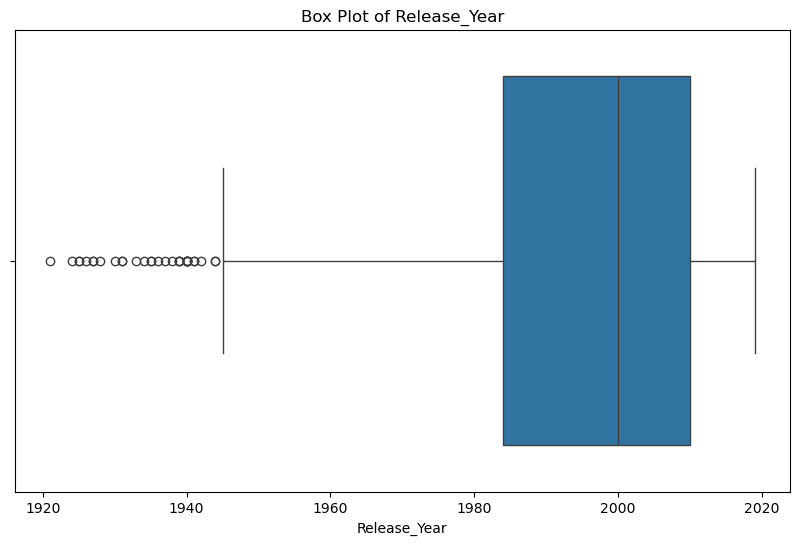

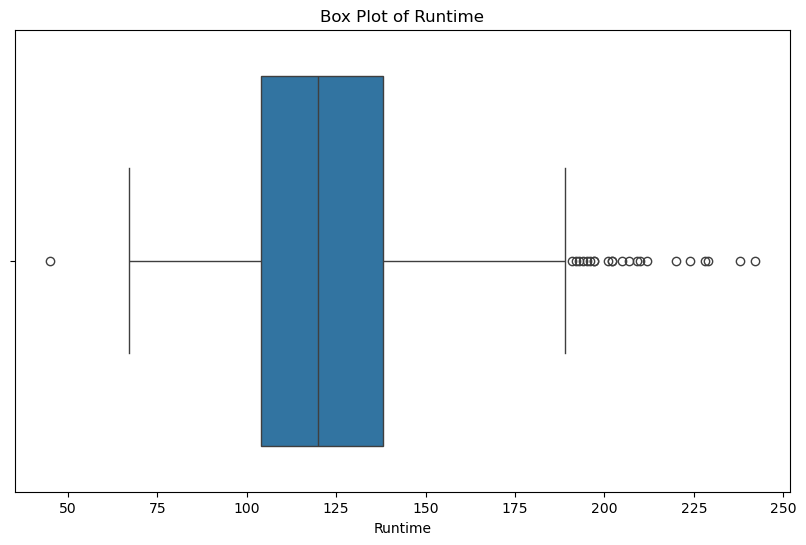

In [10]:
numeric_columns = ["Release_Year", "Runtime"]

for column in numeric_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=data[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

There are several movies in the dataset that were released prior to 1940 which make them not as useful for this analysis and are considered outliers, and will be removed. Additionally, there are several movies that go beyond the 3hr mark and closer to 4hrs. For this analysis, only movies released on or after 1970 (approx. the past 50 years) and a runtime between 1hr and 3.5hr will be considered.

In [11]:
# filtering all movies that were released prior to 1970
data = data[data["Release_Year"] >= 1970]

# filtering all movies that are shorter than 1hr and longer than 3.5hrs
data = data[(data["Runtime"] >= 60) & 
            (data["Runtime"] <= 210)]

After filtering the rows that are not needed and creating another boxplot, many of the outliers have been removed. The reason for not removing all the outliers with respect to runtime is because they contribute 10's to 100's of millions in gross revenue to the movie. Eliminating them would skew the results greatly.

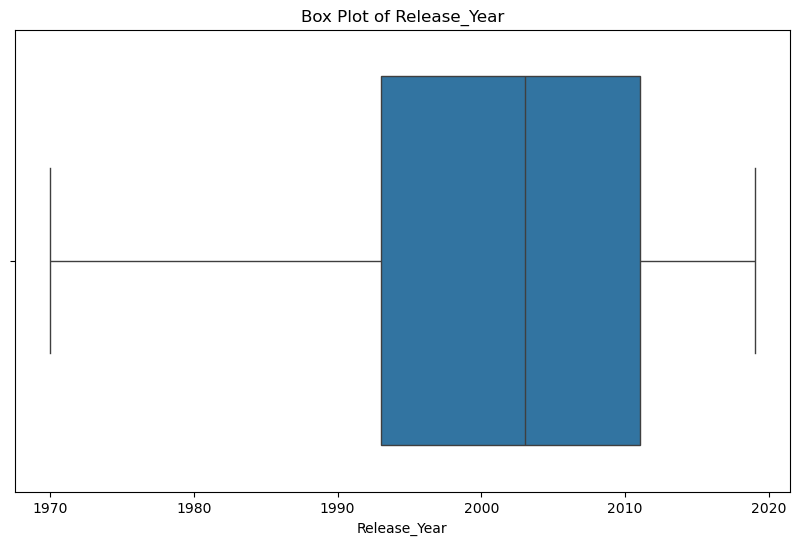

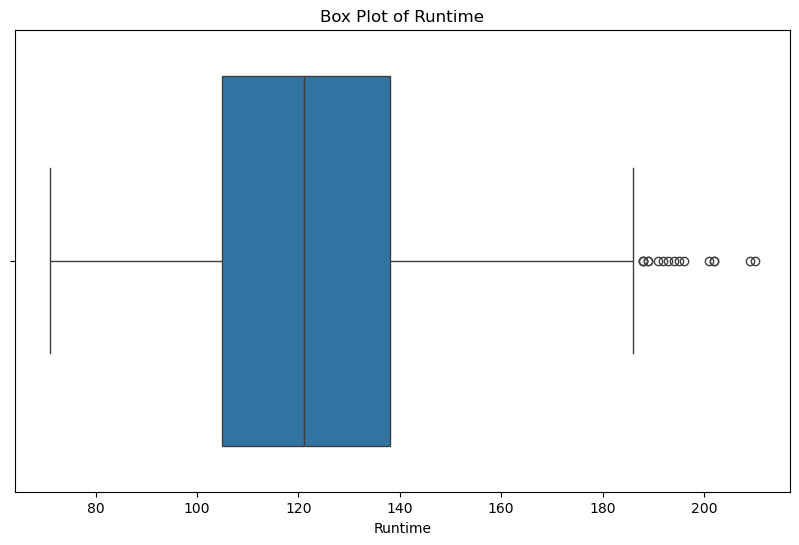

In [12]:
for column in numeric_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=data[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

Upon further inspection, many movies have more than one genre in the `Genre` column. Doing an initial `data["Genre"].value_counts()`, it becomes evident that working with this format will be difficult. In order to understand the distribution of genre's of the dataset, it must be manipulated and broken down. 

In [13]:
# first, a copy of the dataset is made to modify its contents
# second, split the 'Genre' column by its delimiter (comma and space)
# third, explode list into separate rows (ie. if a movie is 'Romance, Comedy' then it will be broken into two rows, 
# one with 'Romance' the other with 'Comedy')
# NOTE: this is an inaccurate representation of the number of rows in the original data set
movie_genres = data.copy()
movie_genres["Genre"] = movie_genres["Genre"].str.split(', ')
movie_genres = movie_genres.explode("Genre")

After breaking down the `Genre` column and running `movie_genres["Genre"].value_counts()`, it is more visually clear just how many movies are part of which genres. 

**NOTE: since each row was subdivided into however many genres the movie was categorized into, the total number of value counts is inaccurate.** (eg. if a movie is 'Romance, Comedy' then it will be broken into two rows, one with 'Romance' the other with 'Comedy' thus being counted twice.)

### **Part 2: Descriptive Statistics and Initial Insights**

#### **Basic Descriptive Statistics**
- what are the average, median, and standard deviation of the movie ratings?
- what is the distribution of movies by genre? which genre is the most common?

In [14]:
data["IMDB_Rating"].mean()

7.9288951841359765

The average IMDB rating for the remaining movies (706, down from 1000) is 7.93 out of 10.

In [15]:
data["IMDB_Rating"].median()

7.9

The median IMDB rating for the movies is 7.9. The average and median are close in range which means the dataset has a symmetrical distribution.

In [16]:
data["IMDB_Rating"].std()

0.28456894923794895

The standard deviation for the IMDB rating is 0.285 which is a measure of how distributed the data is in relation to mean. This closely follows the observation that the data has a symmetrical distribution.

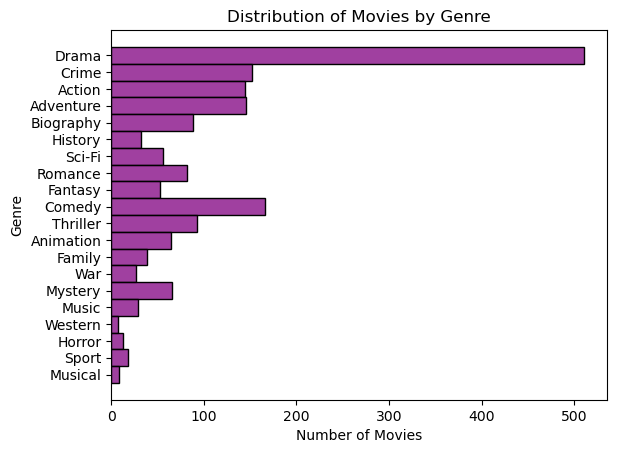

In [17]:
# x="Genre" creates a vertical graph, y="Genre" creates a horizontal graph
sns.histplot(movie_genres, y="Genre", color="purple")
plt.title("Distribution of Movies by Genre")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

The most common genre in the data set is Drama with a count of over 500. The second most common genre is Comedy.

#### **Release Year Analysis**
- what are the distribution of movies by release year?
- are there any trends in movie production over the decades?

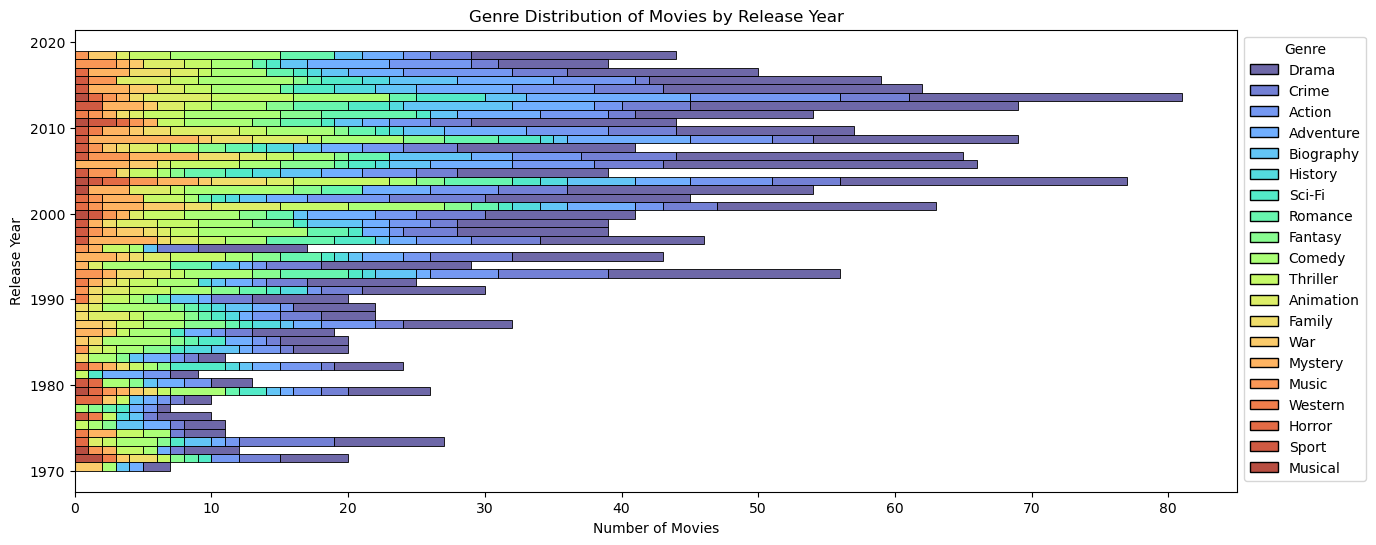

In [18]:
plt.figure(figsize=(15,6))
release_year_genre = sns.histplot(movie_genres, 
             y="Release_Year",
             bins=50, 
             hue="Genre",
             multiple="stack",
             palette=sns.mpl_palette("turbo", 20))

# moves the legend outside the graph
sns.move_legend(release_year_genre, "upper left", bbox_to_anchor=(1,1))
plt.title("Genre Distribution of Movies by Release Year")
plt.xlabel("Number of Movies")
plt.ylabel("Release Year")
plt.show()

The graph above shows the distribution of movies by release year. A common trend is that movies that fall under the "Drama" genre are produced the most often. This is evident as far back as 1972, more than 50 years ago. A possible reason for this could be that almost any movie can be categorized as "Drama" just for having good "dramatic acting", a staple for any film.  

### **Part 3: Deeper Analysis and Visualization**

#### **Rating Analysis**
- how do movie ratings vary by genre?
- are there specific years or decades where higher-rated movies are more common?

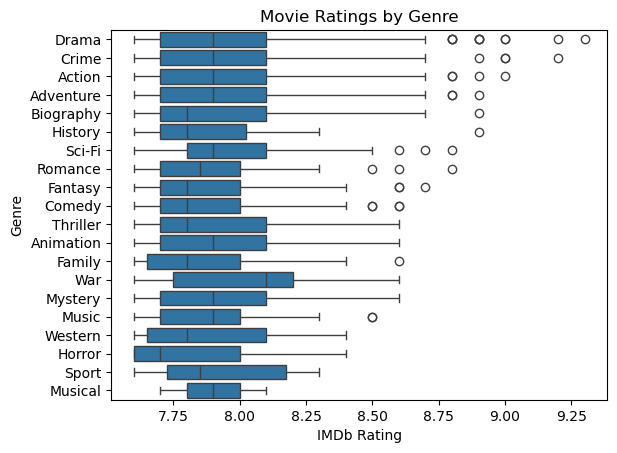

In [19]:
movie_ratings = movie_genres[["Release_Year", "Genre", "IMDB_Rating"]]
sns.boxplot(movie_ratings, x="IMDB_Rating", y="Genre")
plt.title("Movie Ratings by Genre")
plt.xlabel("IMDb Rating")
plt.ylabel("Genre")
plt.show()

Movies in the "War" genre have the highest median rating and movies in the "Horror" genre have the lowest median rating. With that said, the highest rating among all the movies in the dataset is in the "Drama" genre with "Crime" in second.

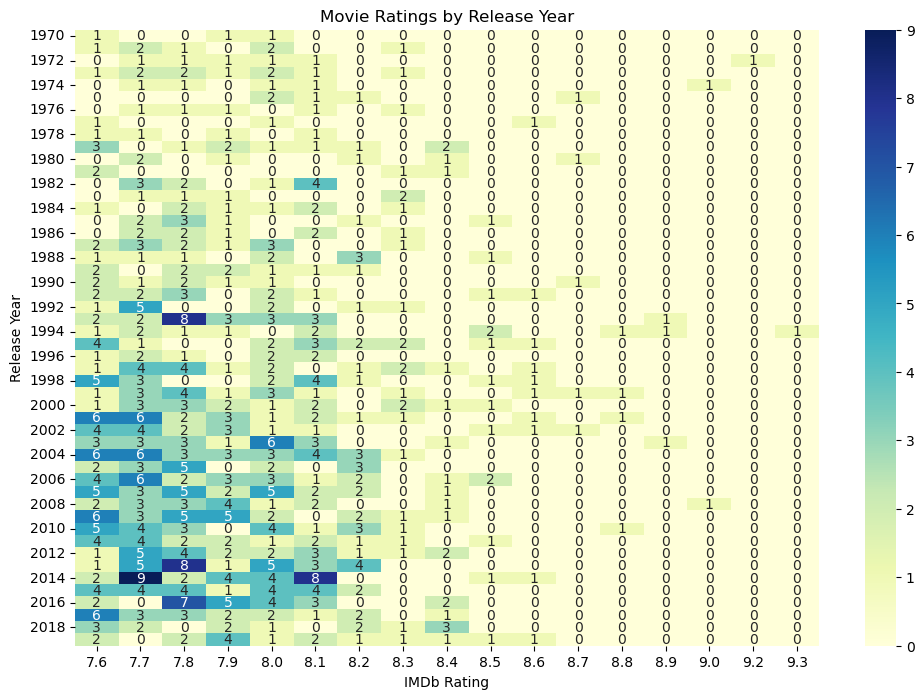

In [20]:
rating_distribution = data.pivot_table(index='Release_Year', columns='IMDB_Rating', aggfunc='size', fill_value=0)

# plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rating_distribution, cmap="YlGnBu", annot=True)
plt.title("Movie Ratings by Release Year")
plt.xlabel("IMDb Rating")
plt.ylabel("Release Year")
plt.show()

While there is no specific year where higher-rated movies are more common, it is a general trend that as we near present-day the number of movies released per year increases. This allows for more movies to reach a greater audience and have a higher average rating. 

#### **Genre and Revenue Analysis**
- which genres tend to generate the highest average revenue?
- which genres have the highest total revenue?

In [21]:
revenue_distribution = movie_genres[["Genre", "Gross"]]

# take the average gross revenue by Genre
revenue_distribution_avg = revenue_distribution.groupby(["Genre"]).mean().round()

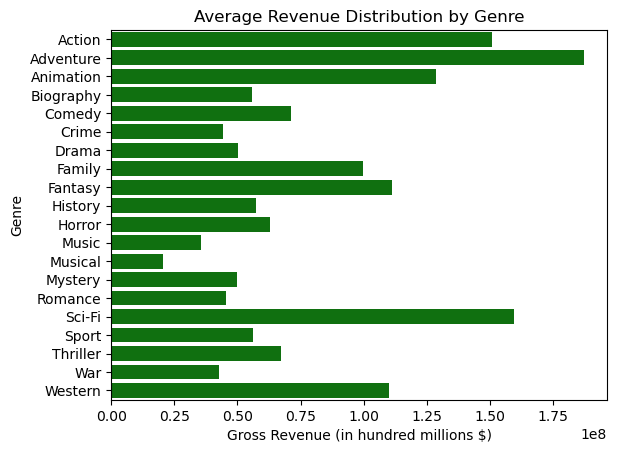

In [22]:
sns.barplot(revenue_distribution_avg, x="Gross", y="Genre", color="green")
plt.title("Average Revenue Distribution by Genre")
plt.xlabel("Gross Revenue (in hundred millions $)")
plt.ylabel("Genre")
plt.show()

The top 3 genres with the highest average revenue are [in order]: Adventure, Sci-Fi and Action. This can be confirmed by doing `revenue_distribution_avg.sort_values(by="Gross", ascending=False)` and those are the first three that appear in that order.

In [23]:
# find the sum of the gross revenue for each Genre
revenue_distribution_total = revenue_distribution.groupby(["Genre"]).sum()

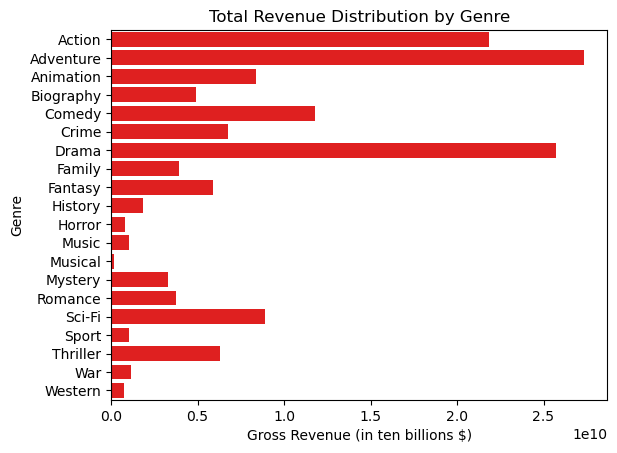

In [24]:
sns.barplot(revenue_distribution_total, x="Gross", y="Genre", color="red")
plt.title("Total Revenue Distribution by Genre")
plt.xlabel("Gross Revenue (in ten billions $)")
plt.ylabel("Genre")
plt.show()

Looking at total revenue instead of average revenue, we find that the top 3 genres are (in order): Adventure, Drama, Action. This can be confirmed by doing `revenue_distribution_total.sort_values(by="Gross", ascending=False)`.

**NOTE:**
- for total and average revenue for ***all*** movies, regardless of genre, use `data["Gross"].sum()` or `data["Gross"].mean()`, respectively.
- for total and average revenue for a ***specific*** genre, see one of the two graphs directly above: total (red) or average (green)

### **Part 4: Advanced Insights**

#### **Director and Actor Analysis**
- who are the top directors based on the number of movies in the top 1000?
- are there any directors whose movies consistently have higher ratings?
- which actors appear most frequently in the top 1000 movies? do these actors have a higher average movie rating?

In [25]:
# find the number of times each director appears in the data set
top_directors = data["Director"].value_counts()
top_directors.head(10)

Director
Steven Spielberg     13
Martin Scorsese      10
Woody Allen           8
Christopher Nolan     8
Quentin Tarantino     8
David Fincher         8
Clint Eastwood        8
Rob Reiner            7
Hayao Miyazaki        7
Wes Anderson          6
Name: count, dtype: int64

Based on the number of movies in the top 1000, Steven Spielberg (13), Martin Scorsese (10) are the two best directors. Woody Allen, Christopher Nolan, Quentin Tarantino, David Fincher, Clint Eastwood are all tied for third place with 8 movies each in the top 1000.

You can manually check that the values below are correct by running: `data[data["Director"] == "[insert director name]"]` and calculating the average from the `IMDB_Rating` column. That value should match with the output from `consistent_directors` in the cell below.

In [26]:
consistent_directors = data.groupby(["Director"])

# only consider directors that have more than 2 movies on the list to ensure consistency and not just a one-time success
consistent_directors = consistent_directors.filter(lambda x: x["Director"].count() > 2)

# find the average IMDb rating for the "consistent" directors and sort in descending order
consistent_directors = consistent_directors.groupby(["Director"])["IMDB_Rating"].mean().sort_values(ascending=False)
consistent_directors

Director
Christopher Nolan       8.462500
Peter Jackson           8.400000
Francis Ford Coppola    8.400000
Stanley Kubrick         8.333333
Rajkumar Hirani         8.200000
                          ...   
Jim Jarmusch            7.733333
Andrey Zvyagintsev      7.733333
John Hughes             7.733333
Spike Lee               7.725000
Matthew Vaughn          7.650000
Name: IMDB_Rating, Length: 69, dtype: float64

In [27]:
# take only the top movie stars and combine them into one [separated by commas]
# drop the columns that are not needed anymore
top_actors = data[["IMDB_Rating", "Star1", "Star2", "Star3", "Star4"]].copy()
top_actors["Cast"] = top_actors["Star1"] + ", " + top_actors["Star2"] + ", " + top_actors["Star3"] + ", " + top_actors["Star4"]
top_actors = top_actors.drop(columns=["Star1", "Star2", "Star3", "Star4"])

# now separate each actor into their own row
top_actors["Cast"] = top_actors["Cast"].str.split(', ')
top_actors = top_actors.explode("Cast")

# find how many movies in the top 1000, the actors has been cast in
top_actors["Cast"].value_counts().head(5)

Cast
Robert De Niro       16
Tom Hanks            13
Al Pacino            13
Brad Pitt            12
Leonardo DiCaprio    11
Name: count, dtype: int64

Robert De Niro (16), Tom Hanks (13), Al Pacino (13), Brad Pitt (12), Leonardo DiCaprio (11) are the top 5 actors that appear the most frequently in the top 1000 movies. 

In [28]:
# calculate which actor has the highest average IMDb Rating
top_actors.groupby("Cast").mean().sort_values(by="IMDB_Rating", ascending=False).head(5)

,IMDB_Rating
Cast,
Bob Gunton,9.3
William Sadler,9.3
Aaron Eckhart,9.0
Caroline Goodall,8.9
John Travolta,8.9


The idea for answering this question was to take all movies that the actor has been cast in, calculate the average IMDb Rating for their movies and sort them in descending order. Then compare whether the *order* was the same as in the previous question (ie. if an actor was cast in the most movies then their average movie rating was also the highest). This was already unlikely to be the case, but this just proves it. 

Using `top_actors[top_actors["Cast"].str.contains("[insert actor name]")]` to check, all the actors in the top 5 with the highest average IMDb Rating are those that are only appear in the main cast of one movie. Actors that have been cast in the most movies in the top 1000 find that their IMDb Rating varies more and lowers their average a little bit. 

#### **Revenue versus Rating**
- is there a correlation between a movie's rating and its revenue?
- do higher-rated movies tend to generate more revenue?

In [29]:
np.corrcoef(data["IMDB_Rating"], data["Gross"])

array([[1.        , 0.14946441],
       [0.14946441, 1.        ]])

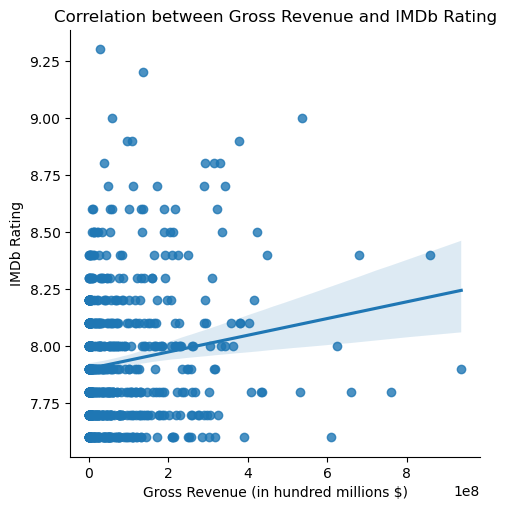

In [30]:
sns.lmplot(data, x="Gross", y="IMDB_Rating")
plt.title("Correlation between Gross Revenue and IMDb Rating")
plt.xlabel("Gross Revenue (in hundred millions $)")
plt.ylabel("IMDb Rating")
plt.show()

Both the correlation matrix and the linear model show that there is a very weak to no relationship. A correlation coefficient of 0.1495 is closer to 0 than it is to 1, which means the relationship between `Gross` and `IMDB_Rating` is positive but very weak. That is to say, a higher revenue does not mean a higher rating and vice versa. 

The second question can be answered based on the first. Since there is a weak positive relationship between `Gross` and `IMDB_Rating`, movies with a higher IMDb Rating do not tend to generate more revenue. There may be a few cases where that is true (because positive relationship), but there are more situations where that is not the case (hence, the weakness). 

#### **Movie Duration Analysis**
- how does the duration of movies vary across different genres?
- is there a relationship between movie duration and ratings or revenue?

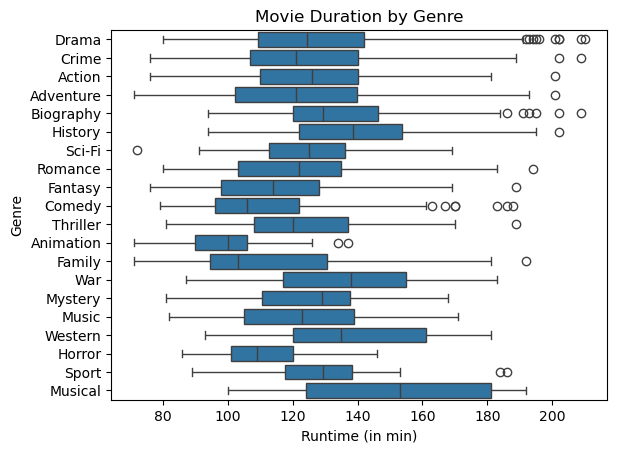

In [31]:
movie_duration_distribution = movie_genres[["Runtime", "Genre", "IMDB_Rating", "Gross"]]
sns.boxplot(movie_duration_distribution, x="Runtime", y="Genre")
plt.title("Movie Duration by Genre")
plt.xlabel("Runtime (in min)")
plt.ylabel("Genre")
plt.show()

On average, movies in the Musical genre have the longest runtime and movies in the Animation genre have the shortest runtime. With that said, the longest movie in the dataset is Drama and the shortest movie is Sci-Fi. More values can be attained by running `movie_genres.sort_values("Runtime", ascending=False)`

In [32]:
np.corrcoef(data["Runtime"], data["IMDB_Rating"])

array([[1.        , 0.29607596],
       [0.29607596, 1.        ]])

The correlation matrix shows that the coefficient is 0.2961 which is not very significant. This means that there is no relationship between movie runtime (`Runtime`) and its rating (`IMDB_Rating`).

In [33]:
np.corrcoef(data["Runtime"], data["Gross"])

array([[1.        , 0.14093379],
       [0.14093379, 1.        ]])

Similarly, the correlation matrix shows that the coefficient is 0.1409 which is even less than the coefficient for `Runtime` and `IMDB_Rating`. This means that there is also no relationship between movie runtime (`Runtime`) and its gross revenue (`Gross`).

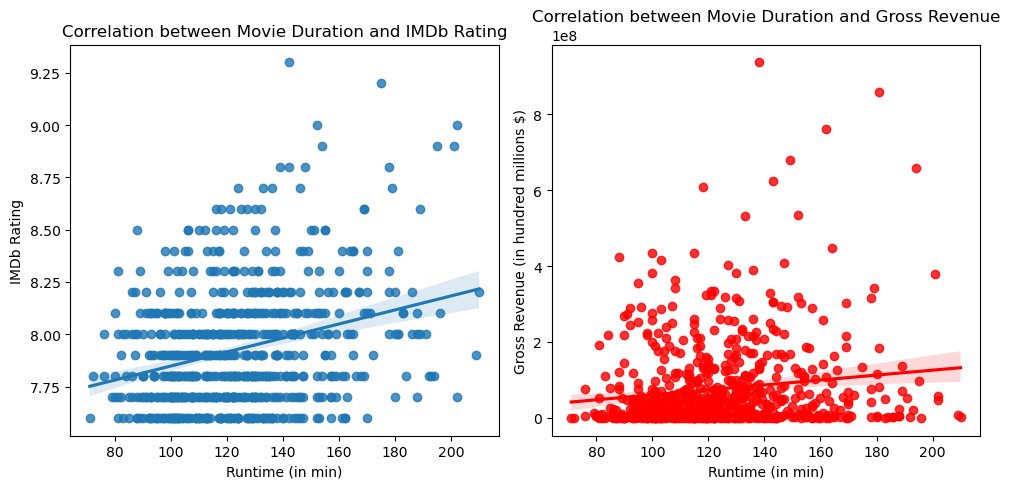

In [34]:
plt.figure(figsize=(10, 5))

# plot 1: movie duration and imdb rating
plt.subplot(1, 2, 1)
sns.regplot(data, x="Runtime", y="IMDB_Rating")
plt.title("Correlation between Movie Duration and IMDb Rating")
plt.xlabel("Runtime (in min)")
plt.ylabel("IMDb Rating")

# plot 2: movie duration and gross revenue
plt.subplot(1, 2, 2)
sns.regplot(data, x="Runtime", y="Gross", color="red")
plt.title("Correlation between Movie Duration and Gross Revenue")
plt.xlabel("Runtime (in min)")
plt.ylabel("Gross Revenue (in hundred millions $)")

# tight_layout() adjusts spacing to prevent overlap
plt.tight_layout() 
plt.show()

Looking at the two graphs above and comparing them with their respective correlation coefficients (0.2961 and 0.1409), it becomes visually evident that there is indeed no relationship between the two variables. After the line of best fit (linear regression model) is drawn, there are way too many points far from the line to say there is any correlation whatsoever. 

### **Part 5: Final Summary and Insights**

In [35]:
# create .csv files for use in Power BI
data.to_csv("imdb_movies_clean.csv")
movie_genres.to_csv("movie_genre_separated.csv")
top_actors.to_csv("actors_subset.csv")

#### **Summary of Findings**
- summarize the key insights gathered from the analysis
- what patterns or trends did you find most surprising or interesting?

Movies that fall under the Drama genre are by far the most common and also have the highest IMDb ratings (not average). Highest and lowest ***average*** IMDb rating would be given to movies categorized under War and Horror genres, respectively. Despite movies in Drama having the highest rating, they do not bring in the most money, that title instead belongs to movies in the Adventure genre for both total and average revenue made. Drama is second for total revenue generated.

The top directors in the industry are Spielberg, Scorsese, Allen, Nolan, Tarantino, Fincher and Eastwood for having directed the most movies that appear in the list of top 1000 IMDb movies. Of these notable directors, it is only Christopher Nolan whose movies have the highest average ratings.

Actors such as Robert De Niro, Tom Hanks, Al Pacino, Brad Pitt and Leonardo DiCaprio are highly spoken of because they are also cast in the most amount of movies. These actors have been cast in numerous movies with a variety of ratings so their *average* rating is lower than those actors who have appeared in one great movie.

Finally, there is no strong evidence to suggest that there is a relationship between a movie's IMDb rating and its gross revenue. There is also no evidence to prove that a correlation exists between movie runtime and rating **or** runtime and gross revenue.

#### **Recommendations**
- based on the analysis, what recommendations could you provide to a movie studio or a director aiming to create a high-rating, high-revenue movie?

Based strictly on the analysis above, my recommendation would be to have Christopher Nolan as director. To create a high-rating, high-revenue movie, Nolan should focus on a story in the **Drama/Adventure** genres.


an aside: 
- **highest average rating:** war, drama/crime/action/adventure/sci-fi...
- **highest overall rating:** drama, crime, action
- **highest average revenue:** adventure, sci-fi, action
- **highest total revenue:** adventure, drama, action

The list above is of the top 3 genres with highest average and total rating/revenue. Funny enough, most of Christopher Nolan's work actually falls into those categories:
- **Oppenheimer** (War/Drama, generated $953 million USD, 8.3 rating)
- **Interstellar** (Sci-fi/Adventure, generated $701 million USD, 8.7 rating)
- **Inception** (Sci-fi/Action, generated $839 million USD, 8.8 rating)
- **The Dark Knight** (Action/Crime, generated $1 billion USD, 9.0 rating)
- **The Dark Knight Rises** (Action/Crime, generated $1 billion USD, 8.4 rating)

#### **Future Improvements**
If I were to repeat a similar project with an updated or different dataset, there is one additional question that I would want to answer:
- is there a correlation between the movie budget and revenue generated?